# Volume 4: Inverse Problems
    Benj McMullin
    Math 439
    2/1/2024

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import quad

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problem 1

Solve (16.2) for a(x).
Produce the plot shown in Figure 16.2.

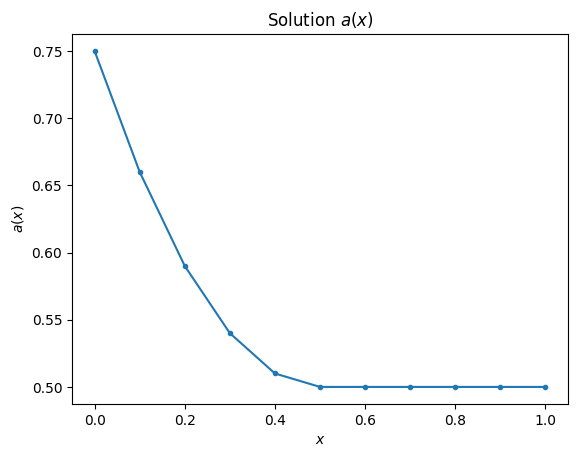

In [2]:
# Define the problem parameters and functions 
c0 = 3/8
c1 = 5/4

# Define the functions u(x) and its derivative du(x)
u = lambda x: x**2 + x/2 + 5/16
du = lambda x: 2*x + 1/2

# Define the function f(x)
def f(x):
    """
    The function f(x) to be integrated
    """
    if x <= 1/2:
        return -6*x**2 + 3*x - 1
    else:
        return -1

# Define the piecewise linear basis functions
N = 10
X = np.linspace(0, 1, N + 1)  # Partition the interval [0, 1] into N subintervals
h = 1 / N  # Length of each subinterval

def phi(x, j):
    """
    The piecewise linear basis function
    
    Parameters:
        x (float): The point at which to evaluate the basis function
        j (int): The index of the basis function
        
    Returns:
        float: The value of the basis function at x
    """
    if X[j - 1] <= x <= X[j]:
        return (x - X[j - 1]) / h
    elif X[j] <= x <= X[j + 1]:
        return (X[j + 1] - x) / h
    else:
        return 0
    
# Iterate through xjs and solve for alphajs 
alphajs = []
for xj in X:
    j = 0
    F = quad(f, 0, xj)[0]  # Integrate f(x) from 0 to xj
    obj = lambda alphaj: (((c0 - F) / alphaj) - du(xj))**2  # Define the objective function to be minimized
    alphaj = minimize(obj, 0.3).x  # Minimize the objective function to find alphaj
    alphajs.append(alphaj)
    j += 1
    
# Plot the solution
plt.plot(X, alphajs, '.-')
plt.title(r"Solution $a(x)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$a(x)$")
plt.show()


# Problem 2

Find the density function a(x). Using several values of ε > 0.66049142, plot the corresponding
density a(x) for x in np.linspace(0,1,11) to demonstrate that the problem is ill-posed.

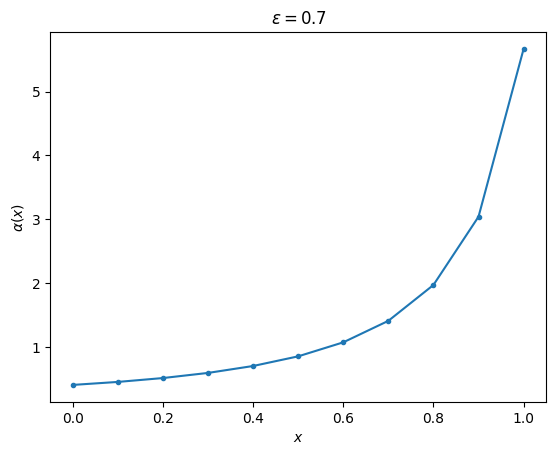

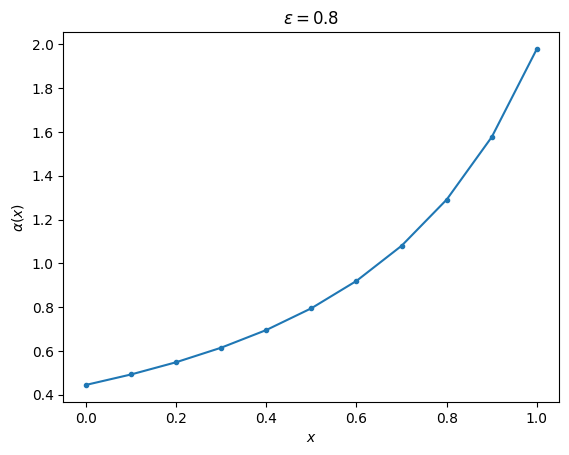

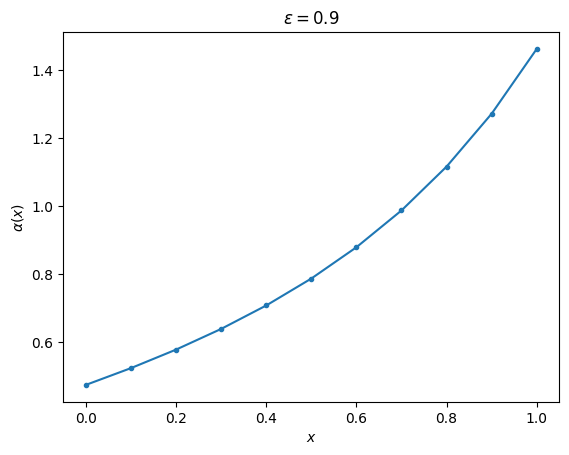

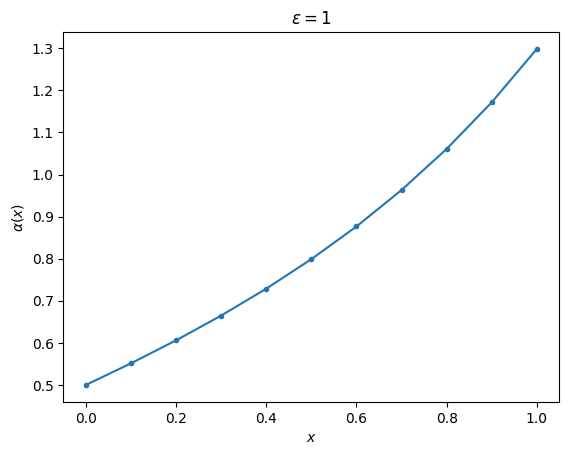

In [3]:
# Initialize parameters and functions
f = lambda x: -1
c0 = 1
c1 = 2
N = 10
X = np.linspace(0, 1, N + 1)  # Define the grid points
h = 1 / N  # Length of each subinterval

# Define functions u(x) and its derivative du(x)
eps = 0.7  # Initial value of epsilon
u = lambda x: x + 1 + eps * np.sin(eps**(-2) * x)
du = lambda x: 1 + np.cos(eps**(-2) * x) / eps

# Iterate through different values of epsilon
for eps in [0.7, 0.8, 0.9, 1]:
    # Iterate through grid points
    alphajs = []
    for xj in X:
        j = 0
        F = quad(f, 0, xj)[0]  # Integrate f(x) from 0 to xj
        # Define the objective function to be minimized
        obj = lambda alphaj: (((c0 - F) / alphaj) - du(xj))**2
        alphaj = minimize(obj, 0.3).x  # Minimize the objective function to find alphaj
        alphajs.append(alphaj)
        j += 1
    
    # Plot the results for each epsilon
    plt.plot(X, alphajs, '.-')
    plt.title(rf"$\epsilon={eps}$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\alpha(x)$")
    plt.show()


# Problem 3
The file measured_heat.npy contains measurements of the temperature along an insulated rod over time, with the first row corresponding to the initial state of the heat distribution in the rod. Use this first row as the initial state of the heat distribution when solving for $U$ with a given vector $\nu$. 
The rod has a varying diffusion coefficient $\nu(x)$. Use equations in the lab, to find a good estimate of $\nu$.
Plot your estimated $\nu$ along with the true $\nu$, which is given by

$\nu(x) = \frac{5}{1+e^{-x}}+\frac{1}{2}$.

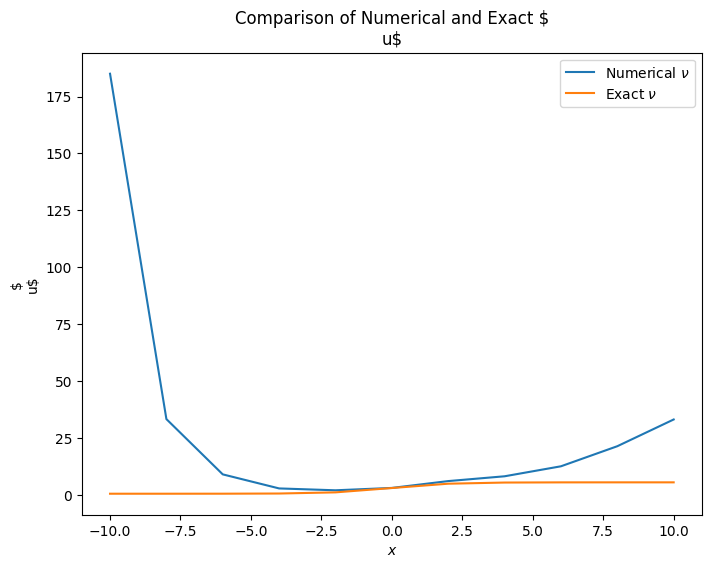

In [4]:
# Load measured heat data
U_measured = np.load('measured_heat.npy')

# Define the objective function J_min
def J_min(nu, U_measured):
    """
    Calculate the minimum value of the objective function J given a specific value of nu.
    
    Parameters:
        nu (ndarray): Array of coefficients representing thermal diffusivity.
        U_measured (ndarray): Array of measured heat data.
        
    Returns:
        float: The value of the objective function J.
    """
    # Initialize the array for the computed heat distribution
    U = np.zeros_like(U_measured)
    U[0] = U_measured[0]  # Initial condition
    
    # Iterate through time steps
    for m in range(0, len(U)-1):
        # Compute the heat distribution at the next time step using finite difference method
        U[m+1, 1:-1] = U[m, 1:-1] + k/(h**2) * ((nu[2:] - nu[:-2]) * (U[m, 2:] - U[m, :-2]) * 0.25 +
                                                nu[1:-1] * (U[m, 2:] - 2*U[m, 1:-1] + U[m, :-2]))
    
    # Compute the value of the objective function (Equation 16.9)
    return np.sum((U - U_measured)**2)

# Define the spatial and temporal grids
xs, h = np.linspace(-10, 10, 11, retstep=True)  # Spatial grid
ts, k = np.linspace(0, 2, 21, retstep=True)     # Temporal grid

# Initial guess for nu based on previous data
guess = np.ones(len(U_measured[0])) * 2

# Minimize the objective function to find the optimal nu
sol = minimize(J_min, guess, args=(U_measured,), method='BFGS')
nu = sol.x

# Plot the numerical and exact solutions for nu
tru_nu = lambda x: 5 / (1 + np.exp(-x)) + 1 / 2  # Exact nu function
plt.figure(figsize=(8, 6))
plt.plot(xs, nu, label=r'Numerical $\nu$')
plt.plot(xs, tru_nu(xs), label=r'Exact $\nu$')
plt.title('Comparison of Numerical and Exact $\nu$')
plt.xlabel('$x$')
plt.ylabel('$\nu$')
plt.legend()
plt.show()
